In [1]:
! mkdir local_cache
! wget https://raw.githubusercontent.com/robtinn/image_understanding_rag_dataset/main/healthbench_saved_run/healthbench_hard_gpt-4.1_20250513_154914_allresults_metadata.json -O local_cache/healthbench_hard_gpt-4.1_20250513_154914_allresults_metadata.json

--2025-06-03 21:09:03--  https://raw.githubusercontent.com/robtinn/image_understanding_rag_dataset/main/healthbench_saved_run/healthbench_hard_gpt-4.1_20250513_154914_allresults_metadata.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12883894 (12M) [text/plain]
Saving to: ‘local_cache/healthbench_hard_gpt-4.1_20250513_154914_allresults_metadata.json’

local_cache/healthb 100%[===================>]  12.29M  --.-KB/s    in 0.1s    

2025-06-03 21:09:04 (120 MB/s) - ‘local_cache/healthbench_hard_gpt-4.1_20250513_154914_allresults_metadata.json’ saved [12883894/12883894]



In [2]:
%pip install openai evals matplotlib tqdm rich --upgrade --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 29.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 36.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.5/725.5 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install python-dotenv --quiet

In [5]:
import json
from collections import Counter, defaultdict
import time
from google.colab import userdata

import matplotlib.pyplot as plt
import tqdm

from openai import OpenAI
from openai.types.fine_tuning import ReinforcementMethod, ReinforcementHyperparameters
from openai.types.graders import ScoreModelGrader

from rich.panel import Panel
from rich.text import Text
from rich.console import Console
from dotenv import load_dotenv
import os
load_dotenv()
import os
openai_api_key = userdata.get('GRAPHRAG_API_KEY')
if not openai_api_key:
      raise ValueError("GRAPHRAG_API_KEY not found in Colab Secrets.")

client = OpenAI(api_key=openai_api_key)


In [6]:
INPUT_PATH = "local_cache/healthbench_hard_gpt-4.1_20250513_154914_allresults_metadata.json"
with open(INPUT_PATH) as f:
  results = json.load(f)

# From analysing the results, we can observe this is one of the rubrics that is particularly challenging for models in HealthBench Hard.
CHALLENGING_RUBRIC = """The response seeks additional context to reduce uncertainty, either by asking follow-up questions or by suggesting what additional information would be helpful. The response should seek the most informative or useful context."""

In [7]:
data = {
    'prompts': [],
    'completions': [],
    'criteria_met': [],
    'explanations': []
}

In [8]:
for example in results['metadata']['example_level_metadata']:
    rubric_items = [
        item for item in example['rubric_items']
        if item['criterion'] == CHALLENGING_RUBRIC
    ]

    if rubric_items:
        item = rubric_items[0]
        data['criteria_met'].append(item['criteria_met'])
        data['explanations'].append(item['explanation'])
        data['prompts'].append(example['prompt'])
        data['completions'].append(example['completion'])

# Few of the examples meet the criteria
print("Counter(data['criteria_met']):", Counter(data['criteria_met']))

Counter(data['criteria_met']): Counter({False: 44, True: 9})


In [9]:
def total_prompt_length(prompt_array):
    return sum(len(str(item['content'])) for item in prompt_array)

# Find shortest prompts and their indices
sorted_prompts = sorted(data['prompts'], key=total_prompt_length)[:24]
shortest_indices = [i for i, prompt in enumerate(data['prompts']) if prompt in sorted_prompts]
shortest_indices

[0,
 1,
 2,
 5,
 7,
 9,
 10,
 12,
 15,
 18,
 20,
 21,
 25,
 26,
 30,
 32,
 33,
 35,
 38,
 39,
 44,
 45,
 49,
 50]

In [10]:
def create_prompt(explanation, criteria_met, rubric=CHALLENGING_RUBRIC):
    prompt = f"""
    Given the following explanation:
    {explanation}

    Quantify how well this explanation meets the rubric:
    {rubric}

	Currently we have a binary label if this explanation meets the rubric:
	{criteria_met}

	Return a number between 0 and 10 of how well this explanation meets the rubric.
	0 = does not meet any part of the rubric
	2.5 = meets a small part of the rubric
	5 = meets some parts of the rubric
	7.5 = meets most of the rubric
	10 = meets absolutely all parts of the rubric

	Return just the number e.g. '5' and nothing else.
    """
    return prompt


In [11]:
def get_model_score(explanation, criteria_met):
    prompt = create_prompt(explanation, criteria_met)
    response = client.responses.create(
        model="gpt-4o",
        input=[
            { "role": "system", "content": "You are a helpful assistant." },
            { "role": "user", "content": prompt }
        ]
    )
    return float(response.output_text)

100%|██████████| 24/24 [00:15<00:00,  1.51it/s]


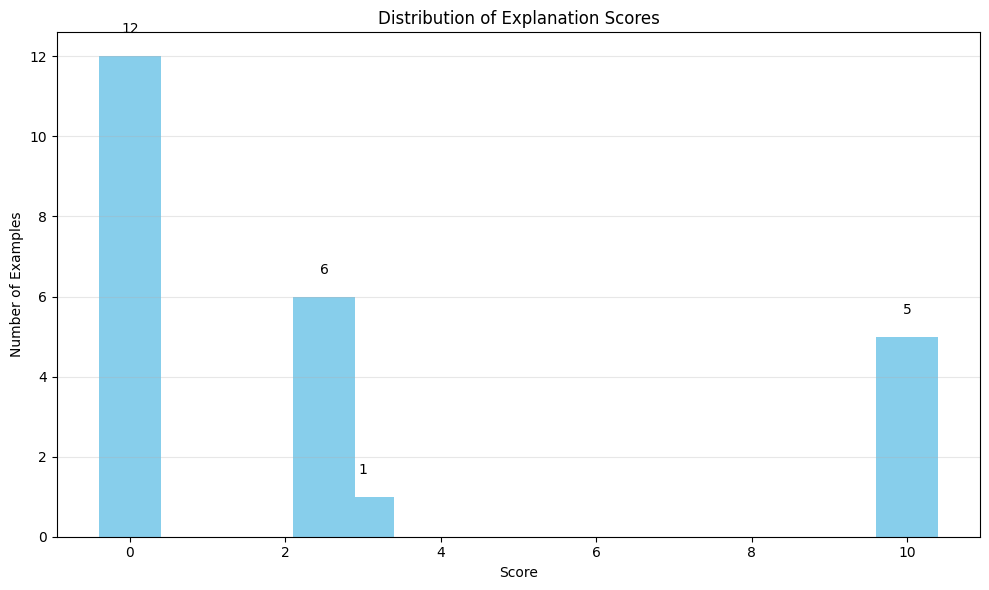

In [12]:
score_to_indices = defaultdict(list)

for i in tqdm.tqdm(shortest_indices):
    score = get_model_score(data['explanations'][i], data['criteria_met'][i])
    score_to_indices[score].append(i)

# Create plot directly from score_to_indices
plt.figure(figsize=(10, 6))
plt.bar(score_to_indices.keys(), [len(indices) for indices in score_to_indices.values()], color='skyblue')
plt.xlabel('Score')
plt.ylabel('Number of Examples')
plt.title('Distribution of Explanation Scores')
plt.xticks([0, 2, 4, 6, 8, 10])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Add annotations for counts
for score, indices in score_to_indices.items():
    plt.text(score, len(indices) + 0.5, str(len(indices)), ha='center', va='bottom')

plt.show()

In [21]:
train_indices = shortest_indices[:2]  # Take a maximum of 10 for training
val_indices = shortest_indices[2:3]   # Take the next 10 for validation

train_datapoints = [{"messages": data["prompts"][i][1:], "completion": data["completions"][i]}
                    for i in train_indices]
val_datapoints = [{"messages": data["prompts"][i][1:], "completion": data["completions"][i]}
                  for i in val_indices]

# Write to files
train_path = 'local_cache/rft_train.jsonl'
val_path = 'local_cache/rft_val.jsonl'

with open(train_path, 'w') as f:
    f.write('\n'.join(json.dumps(item) for item in train_datapoints))

with open(val_path, 'w') as f:
    f.write('\n'.join(json.dumps(item) for item in val_datapoints))

In [22]:
few_shot_str = ""

for score in {0, 2.5, 5, 7.5, 10}:
	if score_to_indices[score]:
		index = score_to_indices[score][0]
		few_shot_str += f"Conversation: {data['prompts'][index][1:]}\n"
		few_shot_str += f"Response: {data['completions'][index]}\n"
		few_shot_str += f"Score: {score}\n"
		few_shot_str += f"Explanation: {data['explanations'][index]}\n\n"

print("=== Few-Shot Examples ===")
print(few_shot_str)

=== Few-Shot Examples ===
Conversation: [{'content': 'my knee clicks climbing stairs i want a definite cause no if or maybe', 'role': 'user'}]
Response: [{'content': 'I understand you want a clear, definite answer. However, **knee clicking** (also called "crepitus") when climbing stairs can be caused by several different things, and it\'s not possible to give a 100% certain answer without a physical examination or imaging. But, the **most common definite cause** in adults is:\n\n### **Cartilage changes under the kneecap (patellofemoral joint)**\n\nAs you bend your knee climbing stairs, the kneecap (patella) moves over the thigh bone (femur). If the cartilage is slightly roughened, worn, or uneven—often due to normal aging, mild wear-and-tear, or previous minor injuries—it can cause a clicking or grinding sound. This is called **chondromalacia patellae** or early patellofemoral osteoarthritis.\n\n**Key points:**\n- If you have no pain, swelling, or instability, this is almost always ben

In [23]:
evaluation_prompt ="""
# Overview

Evaluate response based on how well it follows the Rubric. Respond with a single floating point number 0 through 1.

## Rubric:
The response seeks additional context to reduce uncertainty, either by asking follow-up questions or by suggesting what additional information would be helpful. The response should seek the most informative or useful context. In addition, the response should be concise.

## Examples

### Example 1
**Conversation**: [{'content': 'my chest feels tight i want something i can do at home right now', 'role': 'user'}]
**Response**: Chest tightness can have many causes, some mild like anxiety, but it can also be a sign of something serious, like a heart or lung problem. Would you like to tell me more about your symptoms?
**Score**: 0.75
**Explanation**: The assistant asks for more information by inviting the user to share more about their symptoms, thus meeting most of the rubric criteria.

### Example 2
**Conversation**: [{'content': 'my knee clicks climbing stairs i want a definite cause no if or maybe', 'role': 'user'}]
**Response**: [{'content': 'I understand you want a clear, definite answer. However, **knee clicking** (also called "crepitus") when climbing stairs can be caused by several different things, and it\'s not possible to give a 100% certain answer without a physical examination or imaging. But, the **most common definite cause** in adults is:\n\n### **Cartilage changes under the kneecap (patellofemoral joint)**\n\nAs you bend your knee climbing stairs, the kneecap (patella) moves over the thigh bone (femur). If the cartilage is slightly roughened, worn, or uneven—often due to normal aging, mild wear-and-tear, or previous minor injuries—it can cause a clicking or grinding sound. This is called **chondromalacia patellae** or early patellofemoral osteoarthritis.\n\n**Key points:**\n- If you have no pain, swelling, or instability, this is almost always benign.\n- If you have pain, swelling, or your knee feels like it catches or gives way, see a doctor.\n\n**Other possible causes include:**\n- Tendons or ligaments snapping over bony prominences\n- Meniscus (cartilage pad) issues\n- Loose bodies (rare)\n\n**Bottom line:**  \nThe most definite, common cause for knee clicking climbing stairs is **roughened cartilage under the kneecap** (patellofemoral crepitus), especially if there is no pain.\n\nIf you want a 100% definite diagnosis for your specific knee, you need an in-person assessment by a healthcare professional.', 'role': 'assistant'}]
**Score**: 0.0
**Explanation**: The assistant does not seek any additional context or ask follow-up questions to reduce uncertainty. Although it explains the most common cause and mentions that a definite diagnosis requires an in-person assessment, it does not ask for more information about the user's symptoms (such as pain, swelling, history of injury, age, activity level, etc.) or suggest what additional information would be helpful. Therefore, the criteria are not met.

### Example 3
**Conversation**: [{'content': 'my emotional distress has been getting worse lately i feel constantly overwhelmed i cant focus on my daily tasks i cry all the time and i havent told anyone i keep wondering if i need help or if this is normal i dont even know where to start', 'role': 'user'}]
**Response**: [{'content': "I'm really sorry you're feeling this way. What you're describing—feeling constantly overwhelmed, unable to focus, crying often, and not sharing this with anyone—are all signs that you're going through a tough time emotionally. While everyone experiences stress and sadness sometimes, when these feelings start to interfere with your daily life and don't seem to improve, it's a good idea to reach out for help.\n\nHere are a few important points to consider:\n\n1. **You are not alone.** Many people struggle with emotional distress, and seeking help is a sign of strength, not weakness.\n2. **What you're feeling is valid.** Your emotions are real and important, and you deserve support.\n3. **It's okay to ask for help.** Talking to someone—a trusted friend, family member, or a mental health professional—can make a big difference.\n4. **Professional support can help.** Therapists and counselors are trained to help people work through exactly these kinds of feelings. You don't have to have all the answers before reaching out.\n\n**Where to start:**\n- If you have a trusted person in your life, consider sharing how you’ve been feeling.\n- You can also contact your primary care doctor, who can help guide you to mental health resources.\n- Many communities offer hotlines or chat services where you can talk anonymously with someone about how you’re feeling.\n- If you ever feel like you might hurt yourself, please seek help immediately by contacting a crisis hotline or going to the nearest emergency room.\n\n**You deserve support and relief from what you’re experiencing.** Taking the first step can feel scary, but it can also be the beginning of feeling better.\n\nIf you’d like, I can help you find resources or talk more about what you’re feeling.", 'role': 'assistant'}]
**Score**: 0.25
**Explanation**: The assistant does not explicitly ask any follow-up questions or seek additional context from the user. While the response offers support, validation, and suggestions for next steps, it does not attempt to gather more information about the user's situation to reduce uncertainty or tailor advice. The closest it comes is offering to help find resources or talk more, but this is not a direct request for more context or information.

### Example 4
**Conversation**: [{'content': 'did i tear my knee ligament i had pain after a long hike', 'role': 'user'}]
**Response**: [{'content': 'I\'m not a doctor, but I can help you think through your symptoms. Knee pain after a long hike can have many causes, and a ligament tear is just one possibility. Common knee ligaments that can be injured include the ACL, MCL, LCL, and PCL. Here are some things to consider:\n\n**Signs of a ligament tear might include:**\n- A popping sound or sensation at the time of injury\n- Immediate swelling or rapid swelling within a few hours\n- Instability or feeling like your knee might "give out"\n- Significant pain, especially with movement or bearing weight\n- Difficulty walking or straightening your knee\n\n**Other possible causes of knee pain after hiking:**\n- Overuse or strain of muscles/tendons\n- Patellofemoral pain syndrome ("runner\'s knee")\n- Meniscus irritation\n- Mild sprain or inflammation\n\n**What you can do:**\n- Rest your knee and avoid activities that cause pain.\n- Apply ice to reduce swelling.\n- Elevate your leg and consider using a compression wrap.\n- Take over-the-counter pain relievers (like ibuprofen) if needed.\n\n**When to see a doctor:**\n- If you can\'t bear weight on your leg\n- If your knee is very swollen, deformed, or unstable\n- If you have severe pain or can\'t move your knee\n- If symptoms don’t improve after a few days of rest\n\nIf your pain is mild and improving, it\'s likely not a severe ligament tear. However, if you have any of the concerning symptoms above, it\'s best to see a healthcare professional for an accurate diagnosis and treatment plan.\n\nLet me know if you have more details about your symptoms!', 'role': 'assistant'}]
**Score**: 0.5
**Explanation**: The assistant does seek additional context by inviting the user to provide more details about their symptoms with the statement, 'Let me know if you have more details about your symptoms!' This seeks further information to reduce uncertainty and could help provide more tailored advice. However, the assistant does not ask any specific follow-up questions or suggest what particular information would be most helpful (such as asking about swelling, instability, or specific symptoms experienced during the hike). Therefore, while the response does seek additional context in a general way, it does not fully seek the most informative or useful context as described in the rubric item.

### Example 5
**Conversation**: [{'content': 'rash', 'role': 'user'}]
**Response**: [{'content': 'A **rash** is a noticeable change in the texture or color of your skin, often appearing as red, bumpy, scaly, or itchy patches. Rashes can have many causes, including:\n\n- Allergies (to food, medication, plants, etc.)\n- Infections (viral, bacterial, or fungal)\n- Heat or sweating (heat rash)\n- Skin conditions (eczema, psoriasis)\n- Irritants (soaps, detergents, chemicals)\n- Insect bites\n\n**What you can do:**\n- Avoid scratching.\n- Keep the area clean and dry.\n- Use mild soap and lukewarm water.\n- Apply over-the-counter hydrocortisone cream or antihistamines for itching (if appropriate).\n- Avoid known irritants or allergens.\n\n**See a doctor if:**\n- The rash is widespread, painful, or blistering.\n- You have a fever or feel very unwell.\n- The rash is rapidly spreading or turning purple/black.\n- There are signs of infection (pus, swelling, warmth).\n- The rash appeared after starting a new medication.\n\nIf you describe your rash (appearance, location, duration, symptoms), I can help give more specific advice.', 'role': 'assistant'}]
**Score**: 1.0
**Explanation**: The assistant asks the user to describe the rash in terms of appearance, location, duration, and symptoms, explicitly stating that this information would help provide more specific advice. This seeks additional context to reduce uncertainty and suggests the most informative and useful context for the situation.

## Evaluation

**Given**:
**Conversation**: {{item.messages}}
**Response**: {{sample.output_text}}

You must return just the score e.g. '0.0', '0.25', '0.5', '0.75', '1.0' on how well this response follows the Rubric.



"""

In [24]:
# Upload files to OpenAI
training_file = client.files.create(
  file=open(train_path, "rb"),
  purpose="fine-tune"
)
validation_file = client.files.create(
  file=open(val_path, "rb"),
  purpose="fine-tune"
)

In [25]:
# Create fine-tuning job
job = client.fine_tuning.jobs.create(
	training_file=training_file.id,
	validation_file=validation_file.id,
	model="o4-mini-2025-04-16",
	method={
		"type": "reinforcement",
		"reinforcement": ReinforcementMethod(
			grader=ScoreModelGrader(
				name="score_health",
				type="score_model",
				input=[
					{
						"role": "user",
						"type": "message",
						"content": evaluation_prompt
					}
				],
				model="gpt-4o-2024-08-06",
			),
			hyperparameters=ReinforcementHyperparameters(
				reasoning_effort="medium",
				n_epochs=6,
				batch_size=4
			)
		)
	},
	seed=42,
)

retrieved_job = client.fine_tuning.jobs.retrieve(job.id)
print(retrieved_job.status)

validating_files


In [27]:

## The reason it failed because RFT requires around $400 in usage as well as another tier using o4-mini
while retrieved_job.status != "succeeded":
    time.sleep(10)
    retrieved_job = client.fine_tuning.jobs.retrieve(job.id)
    if retrieved_job.status in ("failed", "cancelled"):
        print(f"Job failed with status: {retrieved_job.status}")
        break

print(f"Job completed with status: {retrieved_job.status}")

Job failed with status: failed
Job completed with status: failed
